In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from PIL import Image

# Set the paths for the dataset
data_dir = r'C:\Users\srine\Downloads\histopathologic-cancer-detection'
train_img_dir = os.path.join(data_dir, 'train')
test_img_dir = os.path.join(data_dir, 'test')

# Load the CSV files
train_labels = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))

# Display the first few rows of the training data
print(train_labels.head())

# 1. Check for missing images
# Add the .tif extension to the image filenames
train_labels['filename'] = train_labels['id'] + '.tif'

# List the available image files in the train folder
available_images = set(os.listdir(train_img_dir))

# Filter the DataFrame to only include rows where the image file exists
train_labels_filtered = train_labels[train_labels['filename'].isin(available_images)]

# Print the number of valid and missing images
print(f"Total images in train folder: {len(available_images)}")
print(f"Valid images in training set: {len(train_labels_filtered)}")
print(f"Missing images: {len(train_labels) - len(train_labels_filtered)}")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Total images in train folder: 220025
Valid images in training set: 220025
Missing images: 0


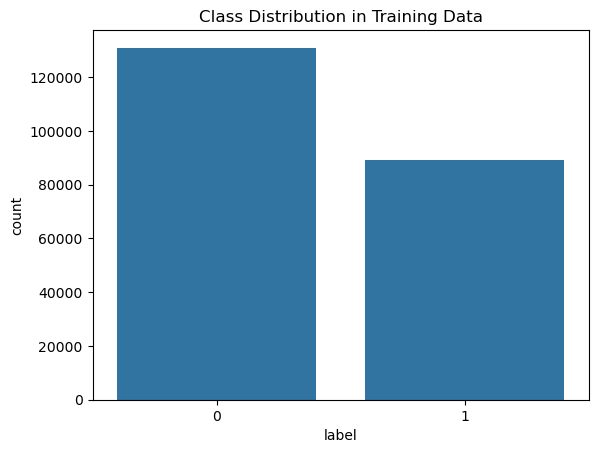

In [16]:
# 2. Visualize class distribution
sns.countplot(x='label', data=train_labels_filtered)
plt.title('Class Distribution in Training Data')
plt.show()

In [18]:
# 3. Data Augmentation and Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    horizontal_flip=True  # Randomly flip images horizontally
)

# Function to generate batches of data for training
def image_data_generator(df, img_folder, batch_size):
    df['label'] = df['label'].astype(str)  # Ensure labels are in string format for binary classification
    
    generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=img_folder,
        x_col='filename',
        y_col='label',
        batch_size=batch_size,
        shuffle=True,
        class_mode='binary',  # Binary classification
        target_size=(32, 32)  # Resizing images to 32x32
    )
    return generator

# Create a generator for training data
train_generator = image_data_generator(train_labels_filtered, train_img_dir, batch_size=64)

Found 220025 validated image filenames belonging to 2 classes.


In [26]:
### Model Architectures ###

# 4. Model 1: Base Model (Three Conv Layers)
def build_base_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary output (0 or 1)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the base model
base_model = build_base_model()
base_model.summary()

# Model 2: Deeper CNN with padding and reduced pooling
def build_deeper_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Removed the fourth MaxPooling layer to prevent excessive downsampling
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary output

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the deeper model
deeper_model = build_deeper_model()
deeper_model.summary()

# Model 3: Batch Normalization Model with padding
def build_batchnorm_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary output

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the batch normalization model
batchnorm_model = build_batchnorm_model()
batchnorm_model.summary()

### Early Stopping Configuration ###
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Model Checkpoints to save the models with `.keras` extension
checkpoint_base = ModelCheckpoint('base_model.keras', monitor='loss', save_best_only=True)
checkpoint_deeper = ModelCheckpoint('deeper_model.keras', monitor='loss', save_best_only=True)
checkpoint_batchnorm = ModelCheckpoint('batchnorm_model.keras', monitor='loss', save_best_only=True)

### Training the Models with EarlyStopping and ModelCheckpoint (5 Epochs) ###
def train_model(model, train_gen, epochs=5, callbacks=None):
    history = model.fit(
        train_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return history

# Check if models already exist, if not, train and save them
import os

if os.path.exists('base_model.keras'):
    print("Loading base_model from saved file.")
    base_model = load_model('base_model.keras')
    history_base = None  # Not available since we didn't retrain
else:
    print("Training base_model...")
    history_base = train_model(base_model, train_generator, epochs=5, 
                               callbacks=[early_stopping, checkpoint_base])

if os.path.exists('deeper_model.keras'):
    print("Loading deeper_model from saved file.")
    deeper_model = load_model('deeper_model.keras')
    history_deeper = None  # Not available since we didn't retrain
else:
    print("Training deeper_model...")
    history_deeper = train_model(deeper_model, train_generator, epochs=5, 
                                 callbacks=[early_stopping, checkpoint_deeper])

if os.path.exists('batchnorm_model.keras'):
    print("Loading batchnorm_model from saved file.")
    batchnorm_model = load_model('batchnorm_model.keras')
    history_batchnorm = None  # Not available since we didn't retrain
else:
    print("Training batchnorm_model...")
    history_batchnorm = train_model(batchnorm_model, train_generator, epochs=5, 
                                    callbacks=[early_stopping, checkpoint_batchnorm])

C:\Users\srine\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,041 (621.25 KB)

 Trainable params: 159,041 (621.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,746,305 (21.92 MB)

 Trainable params: 5,746,305 (21.92 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 618,945 (2.36 MB)

 Trainable params: 618,497 (2.36 MB)

 Non-trainable params: 448 (1.75 KB)

Training base_model...


C:\Users\srine\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 2164s 628ms/step - accuracy: 0.7530 - loss: 0.5120
Epoch 2/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 2076s 604ms/step - accuracy: 0.8062 - loss: 0.4320
Epoch 3/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 2015s 586ms/step - accuracy: 0.8172 - loss: 0.4109
Epoch 4/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 2074s 603ms/step - accuracy: 0.8265 - loss: 0.3920
Epoch 5/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 1964s 571ms/step - accuracy: 0.8332 - loss: 0.3791
Training deeper_model...
Epoch 1/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 2575s 748ms/step - accuracy: 0.7581 - loss: 0.5033
Epoch 2/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 2627s 764ms/step - accuracy: 0.8132 - loss: 0.4150
Training batchnorm_model...
Epoch 1/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 2206s 639ms/step - accuracy: 0.7936 - loss: 0.4876
Epoch 2/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 2260s 657ms/step - accuracy: 0.8385 - loss: 0.3780
Epoch 3/5
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 2155s 627ms/step - accuracy: 0.8561 - loss: 0.3396
Epoch 4/5
3438/3438 ━━━━━━━

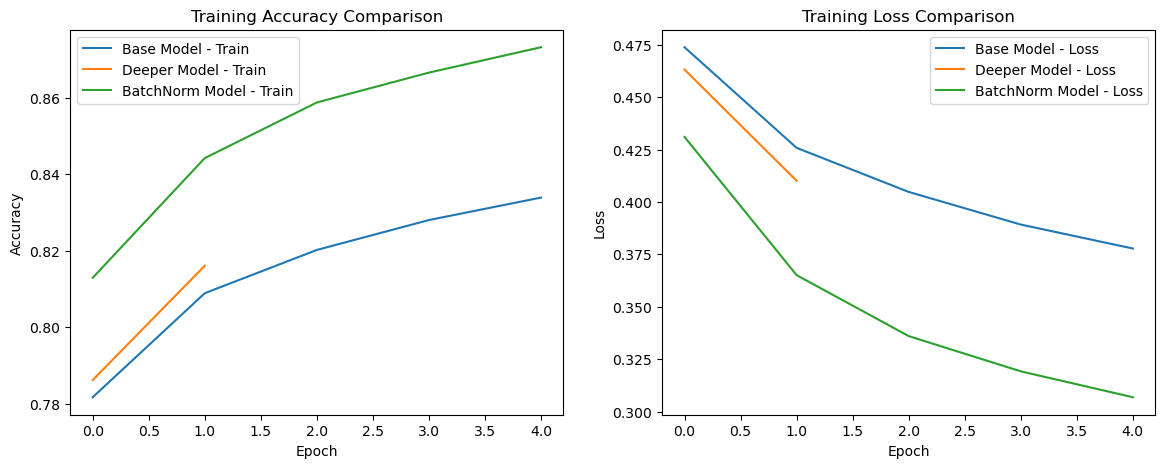

In [28]:
### Plotting the Results ###

def plot_training_history(histories, model_names):
    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        if history is not None:
            plt.plot(history.history['accuracy'], label=f'{name} - Train')
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        if history is not None:
            plt.plot(history.history['loss'], label=f'{name} - Loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot results for all models (only if histories are available)
if any([history_base, history_deeper, history_batchnorm]):
    plot_training_history(
        [history_base, history_deeper, history_batchnorm], 
        ['Base Model', 'Deeper Model', 'BatchNorm Model']
    )

In [34]:
test_img_dir = os.path.join(data_dir, 'test')

# Generate the test_labels DataFrame by listing all files in the test directory
# Assumes filenames in the test directory are image files like 'abc123.tif'
test_image_files = os.listdir(test_img_dir)

# Create a DataFrame with image ids (removing '.tif' extension)
test_labels = pd.DataFrame({
    'id': [f[:-4] for f in test_image_files],  # Removing '.tif' from file names
    'filename': test_image_files
})

# Print the number of valid test images
print(f"Valid test images: {len(test_labels)}")

# Data generator for the test set (no labels, just load images)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory=test_img_dir,
    x_col='filename',  # Use filenames for the images
    y_col=None,  # No labels, we are generating predictions
    batch_size=64,  # Adjust the batch size if necessary
    class_mode=None,  # No labels since it's the test set
    target_size=(32, 32),  # Resize images to 32x32 as expected by the model
    shuffle=False  # Don't shuffle so predictions match the input order
)

# Load your previously saved model (adjust model name if needed)
model_path = 'batchnorm_model.keras'  # Change to correct model path
batchnorm_model = load_model(model_path)

# Calculate total number of steps (batches) to iterate over
num_test_samples = len(test_labels)
batch_size = 64
steps = np.ceil(num_test_samples / batch_size).astype(int)

# Prepare an empty list to hold predictions
predictions = []

# Safeguard: Ensure loop completes without unexpected behavior
try:
    # Manually loop through the generator for the specified number of steps
    for i in range(steps):
        # Get the next batch of data
        batch = next(test_generator)

        # Predict on the current batch
        batch_predictions = batchnorm_model.predict(batch)

        # Add the batch predictions to the predictions list
        predictions.extend(batch_predictions)
                # Progress update
        print(f"Processed batch {i+1}/{steps}")

except StopIteration:
    print("Completed all batches without issue.")

# Convert the predictions list to a NumPy array
predictions = np.array(predictions)

# Ensure predictions and test_labels have the same length
predictions = predictions[:len(test_labels)]

# Convert predictions to binary (0 or 1)
test_labels['label'] = (predictions > 0.5).astype(int)

# Save to submission CSV
submission_file = os.path.join(data_dir, 'submission_batchnorm_model.csv')
test_labels[['id', 'label']].to_csv(submission_file, index=False)

print(f"Predictions saved to {submission_file}.")

Valid test images: 57458
Found 57458 validated image filenames.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
Processed batch 1/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processed batch 2/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processed batch 3/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Processed batch 4/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processed batch 5/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processed batch 6/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Processed batch 7/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Processed batch 8/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processed batch 9/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Processed batch 10/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Processed batch 11/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processed batch 12/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processed batch 13/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Processed batch 14/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processed batch 15/898
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [ ]:
# Import necessary libraries
####HYPER PARAMETER TUNING####
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the model architecture with batch normalization and tuned parameters
def build_tuned_batchnorm_model():
    model = models.Sequential()
    
    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))  # Adjusted dropout rate
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary output

    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to train the model with optional callbacks
def train_model(model, train_gen, epochs=5, callbacks=None):
    history = model.fit(
        train_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return history

# Build the batch normalization model with the tuned parameters
batchnorm_model = build_tuned_batchnorm_model()

# Callbacks for early stopping, learning rate reduction, and model saving
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=1e-6)
checkpoint_batchnorm = ModelCheckpoint('batchnorm_model_tuned.keras', monitor='loss', save_best_only=True)

# Train the model with 10 epochs and the defined callbacks
history_batchnorm = train_model(batchnorm_model, train_generator, epochs=10, 
                                callbacks=[early_stopping, reduce_lr, checkpoint_batchnorm])
